Initial Data Exploration

In [1]:
#Import dependencies

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Read in CSV
raw_data_2022_mn_pm25 = "Data/2022_MN_PM_25.csv"
df_raw_2022_mn_pm25 = pd.read_csv(raw_data_2022_mn_pm25)

In [ ]:
df_raw_2022_mn_pm25

In [ ]:
# Look at unique values for each column
df_raw_2022_mn_pm25.nunique()

In [3]:
# Drop unneeded columns
df_raw_2022_mn_pm25_dropped = df_raw_2022_mn_pm25.drop(columns = ["Source", "Site ID", "DAILY_OBS_COUNT", "PERCENT_COMPLETE", 
                                                                  "AQS_PARAMETER_CODE", "AQS_PARAMETER_DESC", "CBSA_CODE", 
                                                                  "CBSA_NAME", "COUNTY_CODE", "STATE_CODE", "STATE"])
df_raw_2022_mn_pm25_dropped

,Date,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/02/2022,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615
1,01/05/2022,1,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615
2,01/08/2022,1,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615
3,01/11/2022,1,6.7,ug/m3 LC,28,Anoka County Airport,Anoka,45.13768,-93.207615
4,01/14/2022,1,2.6,ug/m3 LC,11,Anoka County Airport,Anoka,45.13768,-93.207615
...,...,...,...,...,...,...,...,...,...
8547,12/25/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8548,12/26/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8549,12/27/2022,3,5.0,ug/m3 LC,21,St. Michael Elementary School,Wright,45.20916,-93.669210
8550,12/28/2022,3,8.7,ug/m3 LC,36,St. Michael Elementary School,Wright,45.20916,-93.669210


In [ ]:
df_raw_2022_mn_pm25["Site Name"].value_counts()

In [ ]:
df_raw_2022_mn_pm25_dropped.columns

In [4]:
# Rename columns
columns = {"Date": "Date", "POC": "POC", "Daily Mean PM2.5 Concentration": "Day_Mean_PM25_Conc", "UNITS": "Units", 
           "DAILY_AQI_VALUE":"Daily_AQI", "Site Name": "Site_Name", "COUNTY": "County", "SITE_LATITUDE": "Latitude",
          "SITE_LONGITUDE": "Longitude"}

df_raw_2022_mn_pm25_rename = df_raw_2022_mn_pm25_dropped.rename(columns = columns)
df_raw_2022_mn_pm25_rename

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude
0,01/02/2022,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615
1,01/05/2022,1,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615
2,01/08/2022,1,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615
3,01/11/2022,1,6.7,ug/m3 LC,28,Anoka County Airport,Anoka,45.13768,-93.207615
4,01/14/2022,1,2.6,ug/m3 LC,11,Anoka County Airport,Anoka,45.13768,-93.207615
...,...,...,...,...,...,...,...,...,...
8547,12/25/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8548,12/26/2022,3,3.6,ug/m3 LC,15,St. Michael Elementary School,Wright,45.20916,-93.669210
8549,12/27/2022,3,5.0,ug/m3 LC,21,St. Michael Elementary School,Wright,45.20916,-93.669210
8550,12/28/2022,3,8.7,ug/m3 LC,36,St. Michael Elementary School,Wright,45.20916,-93.669210


In [5]:
# Add column "AQI_Concern" to reflect AQI category names
df_raw_2022_mn_pm25_rename["AQI_Concern"] = np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 50, "Good", 
                                                     np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 100, "Moderate", 
                                                              np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 150, "Unhealthy for Sensitive Groups", 
                                                                       np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 200, "Unhealthy", 
                                                                                np.where(df_raw_2022_mn_pm25_rename["Daily_AQI"] <= 300, "Very Unhealthy", "Hazardous")))))

In [ ]:
df_raw_2022_mn_pm25_rename

In [ ]:
df_raw_2022_mn_pm25_rename.dtypes

In [6]:
# Change Date column to datetime
df_raw_2022_mn_pm25_rename["Date"] = pd.to_datetime(df_raw_2022_mn_pm25_rename["Date"])
df_raw_2022_mn_pm25_rename.dtypes

Date                  datetime64[ns]
POC                            int64
Day_Mean_PM25_Conc           float64
Units                         object
Daily_AQI                      int64
Site_Name                     object
County                        object
Latitude                     float64
Longitude                    float64
AQI_Concern                   object
dtype: object

In [13]:
df_raw_2022_mn_pm25_rename.groupby(["Site_Name"]).count()

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,County,Latitude,Longitude,AQI_Concern
Site_Name,,,,,,,,,
Andersen School,458,458,458,458,458,458,458,458,458
Anoka County Airport,468,468,468,468,468,468,468,468,468
Apple Valley,491,491,491,491,491,491,491,491,491
B.F. Pearson School,355,355,355,355,355,355,355,355,355
Ben Franklin School,359,359,359,359,359,359,359,359,359
Boundary Waters,413,413,413,413,413,413,413,413,413
Brainerd Lakes Regional Airport,343,343,343,343,343,343,343,343,343
FWS Wetland Management District,338,338,338,338,338,338,338,338,338
Fond du Lac Band,356,356,356,356,356,356,356,356,356


In [7]:
# Look at Anoka separately

anoka_2022_pm25 = df_raw_2022_mn_pm25_rename.loc[df_raw_2022_mn_pm25_rename["Site_Name"] == "Anoka County Airport"]
anoka_2022_pm25

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
0,2022-01-02,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
1,2022-01-05,1,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615,Good
2,2022-01-08,1,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615,Good
3,2022-01-11,1,6.7,ug/m3 LC,28,Anoka County Airport,Anoka,45.13768,-93.207615,Good
4,2022-01-14,1,2.6,ug/m3 LC,11,Anoka County Airport,Anoka,45.13768,-93.207615,Good
...,...,...,...,...,...,...,...,...,...,...
463,2022-12-19,3,9.8,ug/m3 LC,41,Anoka County Airport,Anoka,45.13768,-93.207615,Good
464,2022-12-20,3,7.0,ug/m3 LC,29,Anoka County Airport,Anoka,45.13768,-93.207615,Good
465,2022-12-21,3,8.0,ug/m3 LC,33,Anoka County Airport,Anoka,45.13768,-93.207615,Good
466,2022-12-22,3,4.3,ug/m3 LC,18,Anoka County Airport,Anoka,45.13768,-93.207615,Good


In [8]:
anoka_2022_pm25.loc[anoka_2022_pm25["Date"] == "2022-01-02"]

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
0,2022-01-02,1,13.5,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
120,2022-01-02,3,13.3,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate


In [9]:
anoka_2022_pm25_daily = anoka_2022_pm25[anoka_2022_pm25["POC"] == 3]
anoka_2022_pm25_daily

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
119,2022-01-01,3,9.6,ug/m3 LC,40,Anoka County Airport,Anoka,45.13768,-93.207615,Good
120,2022-01-02,3,13.3,ug/m3 LC,54,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
121,2022-01-03,3,11.7,ug/m3 LC,49,Anoka County Airport,Anoka,45.13768,-93.207615,Good
122,2022-01-04,3,14.5,ug/m3 LC,56,Anoka County Airport,Anoka,45.13768,-93.207615,Moderate
123,2022-01-05,3,3.9,ug/m3 LC,16,Anoka County Airport,Anoka,45.13768,-93.207615,Good
...,...,...,...,...,...,...,...,...,...,...
463,2022-12-19,3,9.8,ug/m3 LC,41,Anoka County Airport,Anoka,45.13768,-93.207615,Good
464,2022-12-20,3,7.0,ug/m3 LC,29,Anoka County Airport,Anoka,45.13768,-93.207615,Good
465,2022-12-21,3,8.0,ug/m3 LC,33,Anoka County Airport,Anoka,45.13768,-93.207615,Good
466,2022-12-22,3,4.3,ug/m3 LC,18,Anoka County Airport,Anoka,45.13768,-93.207615,Good


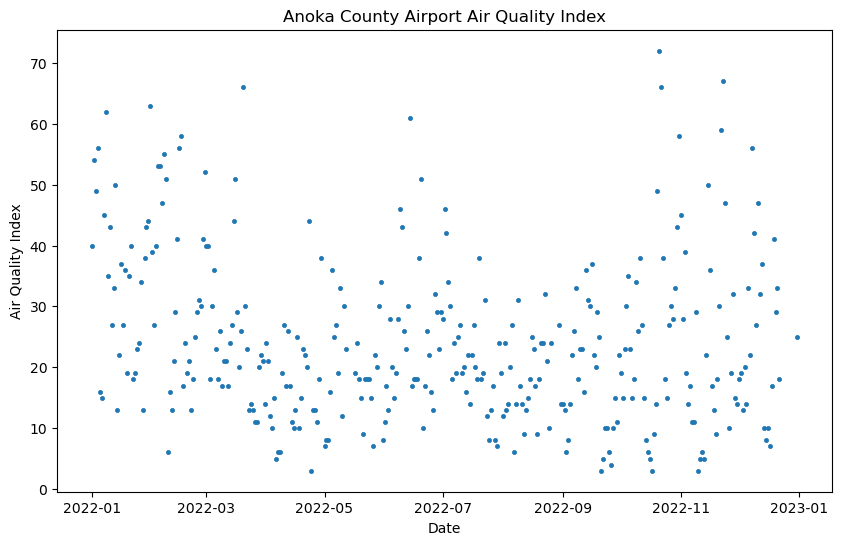

In [10]:
# Graph Anoka County Airport AQI
plt.figure(figsize=(10, 6))
x_values = anoka_2022_pm25_daily["Date"]
y_values = anoka_2022_pm25_daily["Daily_AQI"]
plt.scatter(x_values, y_values, linewidth = 0.5, marker = '.')

plt.title("Anoka County Airport Air Quality Index")
plt.xlabel("Date")
plt.ylabel("Air Quality Index")


plt.show()

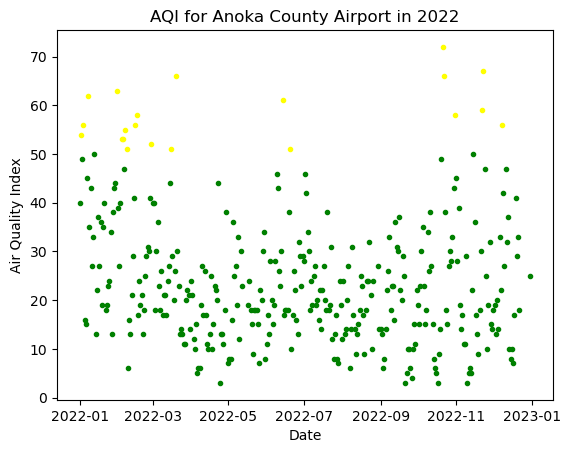

In [11]:
# Make color-coded scatter plot for Anoka County Airport
moderate_bound = 50
unhealthy_for_special_groups_bound = 100
unhealthy_bound = 150
very_unhealthy_bound = 200
hazardous_bound = 300

x = anoka_2022_pm25_daily["Date"]
y = anoka_2022_pm25_daily["Daily_AQI"]

good = np.ma.masked_where(y > moderate_bound, y)
moderate = np.ma.masked_where((y <= moderate_bound) | (y > unhealthy_for_special_groups_bound), y)
unhealthy_special_groups = np.ma.masked_where((y <= unhealthy_for_special_groups_bound) | (y > unhealthy_bound), y)
unhealthy = np.ma.masked_where((y <= unhealthy_bound) | (y > very_unhealthy_bound), y)
very_unhealthy = np.ma.masked_where((y <= very_unhealthy_bound) | (y > hazardous_bound), y)
hazardous = np.ma.masked_where(y <= hazardous_bound, y)

fig, ax = plt.subplots()
ax.scatter(x, good, color = 'green', marker = '.')
ax.scatter(x, moderate, color = 'yellow', marker = '.')
ax.scatter(x, unhealthy_special_groups, color = 'orange', marker = '.')
ax.scatter(x, unhealthy, color = 'red', marker = '.')
ax.scatter(x, very_unhealthy, color = 'purple', marker = '.')
ax.scatter(x, hazardous, color = 'maroon', marker = '.')

plt.xlabel("Date")
plt.ylabel("Air Quality Index")
plt.title("AQI for Anoka County Airport in 2022")

plt.show()

In [22]:
# Generalize the color-coded scatter plot process

def scatter_plot_color(df_name, pollutant_name, location_name, year):
    moderate_bound = 50
    unhealthy_for_special_groups_bound = 100
    unhealthy_bound = 150
    very_unhealthy_bound = 200
    hazardous_bound = 300

    x_values = df_name["Date"]
    y_values = df_name["Daily_AQI"]
    
    good = np.ma.masked_where(y > moderate_bound, y)
    moderate = np.ma.masked_where((y <= moderate_bound) | (y > unhealthy_for_special_groups_bound), y)
    unhealthy_special_groups = np.ma.masked_where((y <= unhealthy_for_special_groups_bound) | (y > unhealthy_bound), y)
    unhealthy = np.ma.masked_where((y <= unhealthy_bound) | (y > very_unhealthy_bound), y)
    very_unhealthy = np.ma.masked_where((y <= very_unhealthy_bound) | (y > hazardous_bound), y)
    hazardous = np.ma.masked_where(y <= hazardous_bound, y)
    
    fig, ax = plt.subplots()
    ax.scatter(x, good, color = 'green', marker = '.')
    ax.scatter(x, moderate, color = 'yellow', marker = '.')
    ax.scatter(x, unhealthy_special_groups, color = 'orange', marker = '.')
    ax.scatter(x, unhealthy, color = 'red', marker = '.')
    ax.scatter(x, very_unhealthy, color = 'purple', marker = '.')
    ax.scatter(x, hazardous, color = 'maroon', marker = '.')

    plt.xlabel("Date")
    plt.ylabel("Air Quality Index")
    plt.title(f'{pollutant_name} AQI for {location_name} in {year}')
    
    plt.show()

In [15]:
# Test function on Andersen School data

andersen_df_pm25_2022 = df_raw_2022_mn_pm25_rename.loc[df_raw_2022_mn_pm25_rename["Site_Name"] == "Andersen School"]
andersen_df_pm25_2022

,Date,POC,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
3752,2022-01-02,1,14.0,ug/m3 LC,55,Andersen School,Hennepin,44.95366,-93.25821,Moderate
3753,2022-01-05,1,3.7,ug/m3 LC,15,Andersen School,Hennepin,44.95366,-93.25821,Good
3754,2022-01-08,1,10.5,ug/m3 LC,44,Andersen School,Hennepin,44.95366,-93.25821,Good
3755,2022-01-11,1,6.2,ug/m3 LC,26,Andersen School,Hennepin,44.95366,-93.25821,Good
3756,2022-01-14,1,3.2,ug/m3 LC,13,Andersen School,Hennepin,44.95366,-93.25821,Good
...,...,...,...,...,...,...,...,...,...,...
4205,2022-12-27,3,5.7,ug/m3 LC,24,Andersen School,Hennepin,44.95366,-93.25821,Good
4206,2022-12-28,3,10.4,ug/m3 LC,43,Andersen School,Hennepin,44.95366,-93.25821,Good
4207,2022-12-29,3,17.1,ug/m3 LC,62,Andersen School,Hennepin,44.95366,-93.25821,Moderate
4208,2022-12-30,3,8.3,ug/m3 LC,35,Andersen School,Hennepin,44.95366,-93.25821,Good


In [21]:
andersen_df_pm25_2022.groupby(["POC"]).count()

,Date,Day_Mean_PM25_Conc,Units,Daily_AQI,Site_Name,County,Latitude,Longitude,AQI_Concern
POC,,,,,,,,,
3,339,339,339,339,339,339,339,339,339


In [18]:
andersen_df_pm25_2022 = andersen_df_pm25_2022[andersen_df_pm25_2022["POC"] == 3]

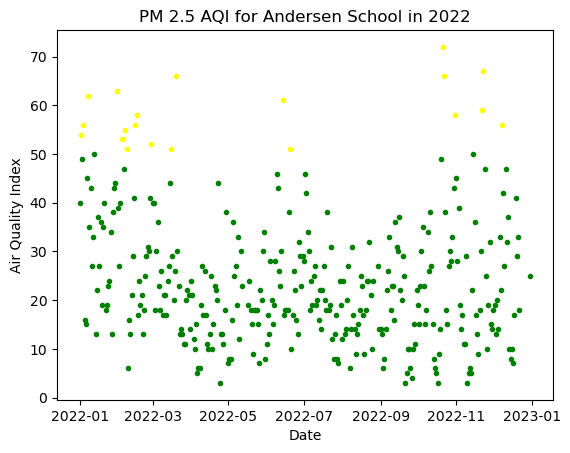

In [24]:
scatter_plot_color(andersen_df_pm25_2022, "PM 2.5", "Andersen School", 2022)